--- 1. GENERATING SYNTHETIC OBSERVATIONS ---
Hidden Parameters: e=0.33, kp=0.18, N=1.0005
Noise Level: 1e-05
Observations generated: 14 points.
--------------------------------------------------

--- 2. SOLVING INVERSE PROBLEM (R.O.M. RECOVERY) ---

--- 3. FINAL RESULTS ---
PARAMETER       | TRUE VALUE   | RECOVERED    | ERROR       
------------------------------------------------------------
Eccentricity    | 0.330000     | 0.330215     | 0.000215
Potential (kp)  | 0.180000     | 0.180016     | 0.000016
------------------------------------------------------------
Fit RMSE: 0.000007666

Plotting results...


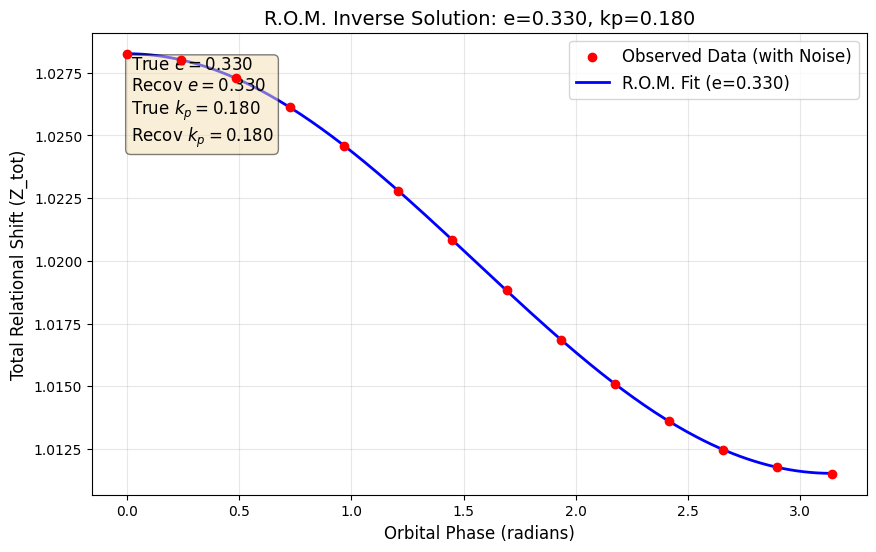

Done.


In [12]:
"""
WILL RG DERIVED RELATIONAL ORBITAL MECHANICS (R.O.M.)
Proof of Concept: Signal Decomposition & Parameter Recovery

Objective:
    Recover the hidden orbital geometry (eccentricity 'e') and
    gravitational potential ('kp') of a two-body system solely from
    the total scalar redshift signal (Z_tot) sampled over time.

Methodology:
    1. Input: A time-series of total redshift Z_tot = (1+z_grav)(1+z_doppler).
    2. Constraint: The System Shift (N) is assumed known (calibrated).
    3. Model: R.O.M. Closed Algebraic System.
       - Energy Invariant (W) links Potential (kappa) and Kinetic (beta) projections.
       - Phase rojections k_X and b_Y determine the total shift.
    4. Solver: Global Differential Evolution to minimize RMSE between
       observed data and the R.O.M. prediction.

Author: Anton Rize
Date: February 2026
"""

import numpy as np
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt

# ==========================================
# PART 1: THE THEORETICAL MODEL (R.O.M.)
# ==========================================

def rom_calculate_signal(phases, e, kp, N):
    """
    Calculates the Total Shift Z_tot for a given orbital phase and parameters.

    Args:
        phases (array): Orbital phases in radians (0 to pi).
        e (float): Eccentricity [0, 1).
        kp (float): Potential projection at perihelion [0, 1).
        N (float): System Doppler shift (Calibration constant).

    Returns:
        np.array: The theoretical Z_tot signal.
    """
    # 1. Energy Invariant (W)
    # Conservation law linking geometry and potential strength.
    W = 0.25 * (kp**2) * (1.0 - e)

    # 2. Local Potential Projection (kappa_o) at phase 'o'
    # Based on radial distance modulation.
    # Formula: kp * sqrt( (1 + e*cos(o)) / (1 + e) )
    ko_sq = (kp**2) * (1.0 + e * np.cos(phases)) / (1.0 + e)

    # Safety clip to prevent numerical errors below zero
    ko_sq = np.maximum(ko_sq, 0.0)
    ko = np.sqrt(ko_sq)

    # 3. Local Kinetic Projection (beta_o)
    # Derived from the Energy Invariant: beta^2 = kappa^2 - 2W
    bo_sq = ko_sq - 2 * W

    # 4. Causal Constraints (Physics Check)
    # If parameters yield non-physical velocities (complex numbers), return None
    if np.any(bo_sq < 0) or np.any(bo_sq >= 1.0) or np.any(ko_sq >= 1.0):
        return None

    # 5. Phase projections
    # k_Xo: Gravitational time dilation factor
    # b_Yo: Transverse Doppler factor
    k_Xo = np.sqrt(1.0 - ko_sq)
    b_Yo = np.sqrt(1.0 - bo_sq)

    # 6. Total Relational Shift Z_sys
    # The combined scalar invariant.
    Z_sys = 1.0 / (k_Xo * b_Yo)

    # 7. Apply System Calibration (N)
    return Z_sys * N

# ==========================================
# PART 2: THE FORWARD PROBLEM (Simulation)
# ==========================================

def generate_synthetic_data():
    print("--- 1. GENERATING SYNTHETIC OBSERVATIONS ---")

    # TRUE HIDDEN PARAMETERS (The "Reality")
    true_e = 0.33      # Eccentricity
    true_kp = 0.18     # Potential at Perihelion
    true_N = 1.0005    # System moving away slightly (Redshift)

    noise_level = 0.00001 # High-precision instrument noise

    # Observation phases (e.g., 14 measurements over half an orbit)
    phases_obs = np.linspace(0, np.pi, 14)

    # Generate the "True" physics signal
    z_pure = rom_calculate_signal(phases_obs, true_e, true_kp, true_N)

    # Add instrumental noise
    np.random.seed(42) # For reproducibility
    noise = np.random.normal(0, noise_level, len(phases_obs))
    z_observed = z_pure + noise

    print(f"Hidden Parameters: e={true_e}, kp={true_kp}, N={true_N}")
    print(f"Noise Level: {noise_level}")
    print(f"Observations generated: {len(z_observed)} points.")
    print("-" * 50)

    return phases_obs, z_observed, true_N, (true_e, true_kp)

# ==========================================
# PART 3: THE INVERSE PROBLEM (Solver)
# ==========================================

def solve_inverse_problem(phases, z_obs, known_N):
    print("\n--- 2. SOLVING INVERSE PROBLEM (R.O.M. RECOVERY) ---")

    # Objective Function: Minimize RMSE (Root Mean Square Error)
    def objective(params):
        e_guess, kp_guess = params

        # Calculate model prediction
        z_model = rom_calculate_signal(phases, e_guess, kp_guess, known_N)

        # Penalty for non-physical parameters
        if z_model is None:
            return 1e9

        # Calculate Residuals
        rmse = np.sqrt(np.mean((z_obs - z_model)**2))
        return rmse

    # Search Bounds
    # e: [0, 0.99], kp: [0.001, 0.99]
    bounds = [(0.0, 0.99), (0.001, 0.99)]

    # Optimization: Differential Evolution (Global Search)
    # Strategy 'best1bin' with 'polish=True' ensures high precision convergence.
    result = differential_evolution(
        objective,
        bounds,
        strategy='best1bin',
        maxiter=3000,
        popsize=40,
        tol=1e-9,
        seed=42,
        polish=True
    )

    return result.x, result.fun

# ==========================================
# PART 4: EXECUTION & VALIDATION
# ==========================================

if __name__ == "__main__":
    # 1. Get Data
    phases, z_data, calibration_N, truth = generate_synthetic_data()

    # 2. Run Solver (Blindly)
    recovered_params, final_error = solve_inverse_problem(phases, z_data, calibration_N)
    rec_e, rec_kp = recovered_params

    # 3. Report Results
    print(f"\n--- 3. FINAL RESULTS ---")
    print(f"{'PARAMETER':<15} | {'TRUE VALUE':<12} | {'RECOVERED':<12} | {'ERROR':<12}")
    print("-" * 60)
    print(f"{'Eccentricity':<15} | {truth[0]:<12.6f} | {rec_e:<12.6f} | {abs(truth[0]-rec_e):.6f}")
    print(f"{'Potential (kp)':<15} | {truth[1]:<12.6f} | {rec_kp:<12.6f} | {abs(truth[1]-rec_kp):.6f}")
    print("-" * 60)
    print(f"Fit RMSE: {final_error:.9f}")

    # 4. Visualization
    print("\nPlotting results...")

    # Generate smooth model curve for plotting
    smooth_phases = np.linspace(0, np.pi, 200)
    smooth_z = rom_calculate_signal(smooth_phases, rec_e, rec_kp, calibration_N)

    plt.figure(figsize=(10, 6))
    plt.scatter(phases, z_data, color='red', label='Observed Data (with Noise)', zorder=5)
    plt.plot(smooth_phases, smooth_z, 'b-', linewidth=2, label=f'R.O.M. Fit (e={rec_e:.3f})')

    plt.title(f'R.O.M. Inverse Solution: e={rec_e:.3f}, kp={rec_kp:.3f}', fontsize=14)
    plt.xlabel('Orbital Phase (radians)', fontsize=12)
    plt.ylabel('Total Relational Shift (Z_tot)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)

    # Add text box with parameters
    textstr = '\n'.join((
        r'$\mathrm{True}\ e=%.3f$' % (truth[0], ),
        r'$\mathrm{Recov}\ e=%.3f$' % (rec_e, ),
        r'$\mathrm{True}\ k_p=%.3f$' % (truth[1], ),
        r'$\mathrm{Recov}\ k_p=%.3f$' % (rec_kp, )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    plt.show()
    print("Done.")